In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
from scipy.stats import binned_statistic, powerlaw, binned_statistic_2d
from scipy.interpolate import interp1d
import kmeans_radec
import seaborn
from astropy.io import ascii

import Setup as p

import SelectionFunc

/mnt/zfsusers/rstiskalek/src/Code/SelectionFunc.py:150: RuntimeWarning: overflow encountered in exp
  return -np.exp(a*x+b) + c*x + d
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [8]:
data = ascii.read("../../Data/SMmatching/a70_160624.csv")
RA = np.array(data['HIra'])
DEC = np.array(data['HIdec'])
logMH = np.array(data['loghimass'])
dist = np.array(data['dist'])

IDS = np.where(logMH>0)
RA = RA[IDS]
DEC = DEC[IDS]
logMH = logMH[IDS]
dist = dist[IDS]

IDS = np.where(np.logical_and(RA>100, RA < 270))
RA = RA[IDS]
DEC = DEC[IDS]
logMH = logMH[IDS]
dist = dist[IDS]

IDS = np.where(np.logical_and(DEC>-0.2, DEC < 19))
RA = RA[IDS]
DEC = DEC[IDS]
logMH = logMH[IDS]
dist = dist[IDS]

12237
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


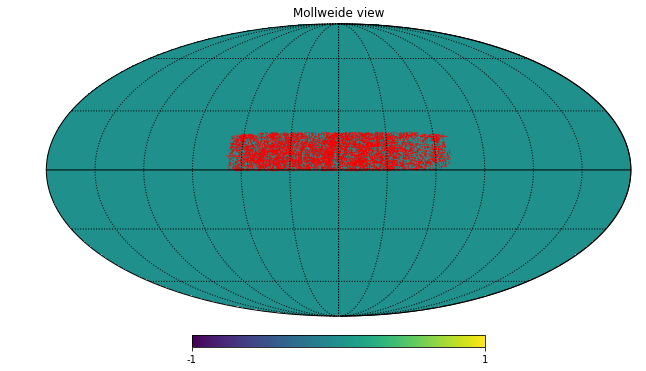

In [9]:
print(dist.size)
hp.mollview(np.zeros(12), rot=180)
hp.graticule()
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA), s=0.05, c='red')

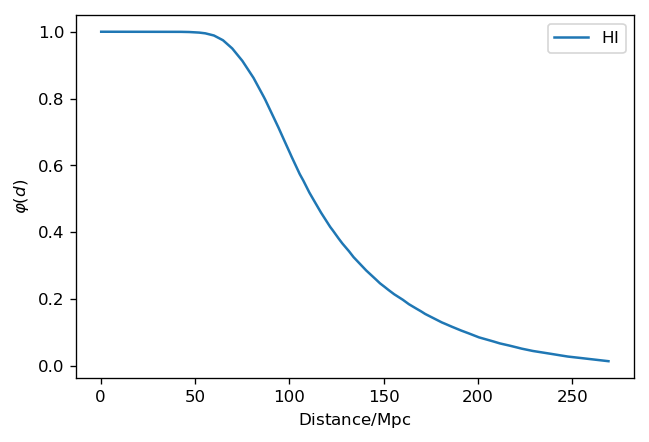

In [10]:
# Get selection func
logMHlim = 9.0

dist_arr = np.linspace(dist.min(), dist.max(), 1000)

y = SelectionFunc.survival_func_HI(dist_arr, logMHlim, 151)(dist_arr)

surv_func = interp1d(dist_arr, y)
# plt.figure(figsize=(figwidth, figheight) ,dpi=240)
plt.figure(dpi=120)
plt.plot(dist_arr, y, label=r"$\mathrm{HI}$")
plt.ylabel(r"$\varphi(d)$")
plt.xlabel(r"$\mathrm{Distance}/\mathrm{Mpc}$")
plt.legend()
plt.show()

666666
92791


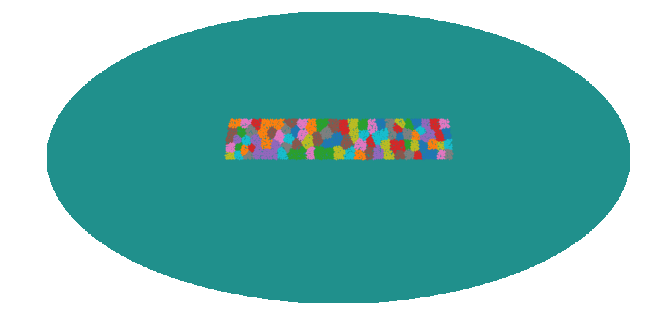

In [11]:
# Generate a random catalog
Nrands = 5e5
Nrands_target = int(Nrands/0.75)
RAmin, RAmax = np.deg2rad(RA.min()), np.deg2rad(RA.max())
arcsinDECmin, arcsinDECmax = np.arcsin(np.deg2rad(DEC.min())), np.arcsin(np.deg2rad(DEC.max()))
distmin, distmax = dist.min(), dist.max()

randRA = np.rad2deg(np.random.uniform(RAmin, RAmax, Nrands_target))
randDEC = np.rad2deg(np.arcsin(np.random.uniform(arcsinDECmin, arcsinDECmax, Nrands_target)))
randdist = powerlaw.rvs(a=3, loc=distmin, scale=distmax-distmin, size=Nrands_target)


# Cluster the galaxies for jackknifing
N = randRA.size
Ncluster = 10000
IDS = np.random.choice(np.arange(N), Ncluster, False)
X = np.vstack([randRA[IDS], randDEC[IDS]]).T
km = kmeans_radec.kmeans_sample(X, p.ncent, maxiter=250, tol=1.0e-5, verbose=0)

X = np.vstack([randRA, randDEC]).T
randLabels = km.find_nearest(X)

hp.mollview(np.zeros(12), rot=180, title='', cbar=False)
for label in np.unique(km.labels):
    IDSlab = np.where(km.labels==label)
    hp.projscatter(np.pi/2-np.deg2rad(randDEC[IDS][IDSlab]), np.deg2rad(randRA[IDS][IDSlab]), s=0.5)
    
# Apply selection effects to the rand.
N = randdist.size
print(N)

prob_surv = surv_func(randdist)
# Don't forget RFI..
hvel = list()
for r, d, distance in zip(np.deg2rad(randRA), np.deg2rad(randDEC), randdist):
    hvel.append(SelectionFunc.heliovelocity([r, d, distance]))
hvel = np.array(hvel)

prob_rfi = SelectionFunc.survival_func_rfi(hvel)
# prob_rfi=1

prob_arr = prob_surv*prob_rfi
rand_arr = np.random.uniform(0, 1, N)

IDS = np.where((prob_arr-rand_arr) > 0)
randdist = randdist[IDS]
randRA = randRA[IDS]
randDEC = randDEC[IDS]
randLabels = randLabels[IDS]
print(randdist.size)

N. gal above this mass cut 10422


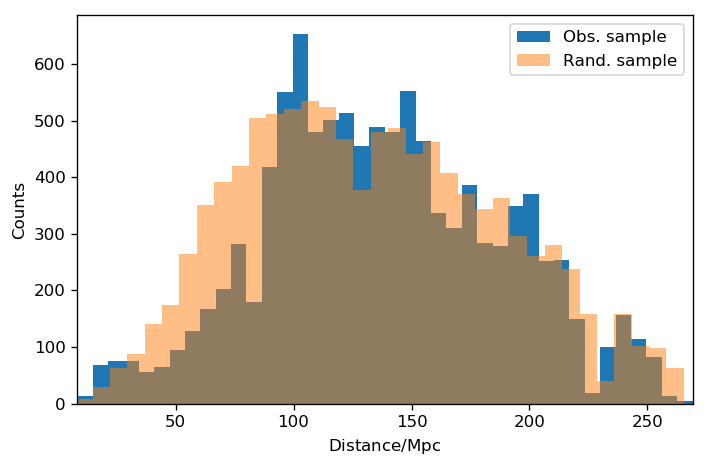

In [12]:
# Plot how do the histograms differ
IDS = np.where(logMH>logMHlim)
print("N. gal above this mass cut", IDS[0].size)


# Downsample randcat to the same size as catalog
IDS2 = np.random.choice(np.arange(randdist.size), dist[IDS].size, replace=False)

# plt.figure(figsize=(figwidth, figheight) ,dpi=240)
plt.figure(dpi=120)

plt.hist(dist[IDS], bins='auto', label="Obs. sample")
plt.hist(randdist[IDS2], bins='auto', label="Rand. sample", alpha=0.5)
plt.ylabel(r"Counts")
plt.xlabel(r"Distance$/\mathrm{Mpc}$")
plt.xlim(dist[IDS].min(), dist[IDS].max())
plt.legend()
plt.tight_layout()
plt.show()

Number density is 0.010464351035468857


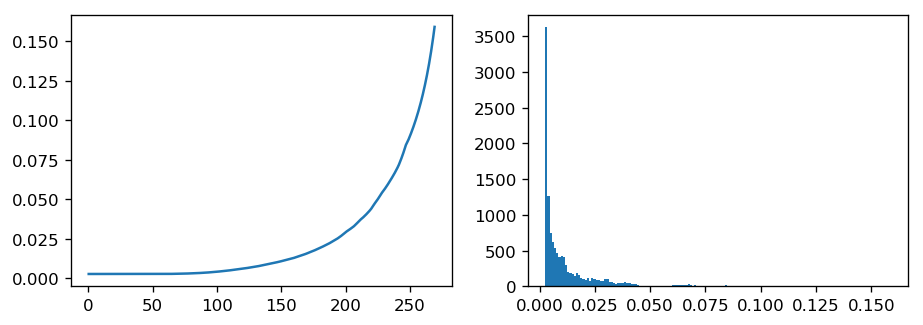

In [13]:
MFWascii = ascii.read("../../Data/HIdata/a100.180315.MWF.csv")
MFW = np.zeros(shape=(25, 18))
for i in range(25):
    for j in range(18):
        MFW[i, j] = MFWascii[i][j]

massbins = [6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2,
            8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0]
w50bins = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]

number_density = 0
mlow_ind = np.abs(logMHlim-np.array(massbins)).argmin()

for i in range(len(w50bins)-1):
    dw50 = w50bins[i+1]-w50bins[i]
    w50 = (w50bins[i+1]+w50bins[i])/2

    for j in range(mlow_ind, len(massbins)-1):
        dm = massbins[j+1]-massbins[j]
        number_density += MFW[j, i]*dm*dw50

print("Number density is {}".format(number_density))

J3 = 2962

def get_weights(dist):
    return 1/(1+4*np.pi*number_density*J3*surv_func(dist))

plt.figure(dpi=120, figsize=(9,3))

plt.subplot(121)
plt.plot(dist_arr, get_weights(dist_arr))

plt.subplot(122)
plt.hist(get_weights(dist), bins='auto')

plt.show()

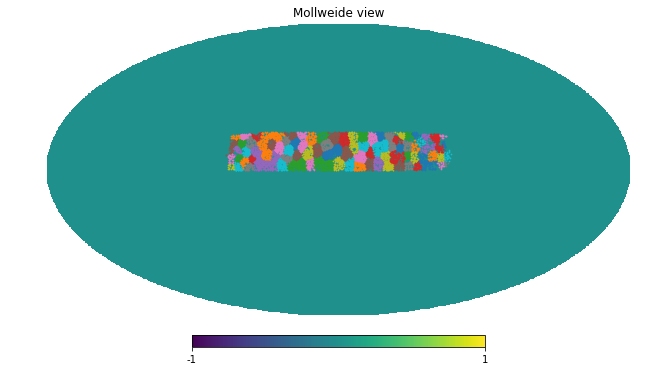

In [14]:
N = randdist.size
perc = "HItest"
random_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'label', 'weights'),
                                'formats':('float64', 'float64', 'float64', 'int64', 'float64')})
random_catalog['ra'] = randRA
random_catalog['dec'] = randDEC
random_catalog['dist'] = randdist
random_catalog['label'] = randLabels
# random_catalog['weights'] = np.ones_like(randRA)
random_catalog['weights'] = get_weights(randdist)

np.save("../../Data/SMmatching/CFrandcatSM_{}_.npy".format(perc), random_catalog)

IDS = np.where(logMH>logMHlim)
RAcut = RA[IDS]
DECcut = DEC[IDS]
Distcut = dist[IDS]

X = np.vstack([RAcut, DECcut]).T

N = Distcut.size

cut_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'weights', 'label'),
                                'formats':('float64', 'float64', 'float64', 'float64', 'int64')})
cut_catalog['ra'] = RAcut
cut_catalog['dec'] = DECcut
cut_catalog['dist'] = Distcut
cut_catalog['weights'] = get_weights(Distcut)
cut_catalog['label'] = km.find_nearest(X)
# cut_catalog['weights'] = np.ones_like(RAcut)

np.save("../../Data/SMmatching/CFcatSM_{}_.npy".format(perc), cut_catalog)

hp.mollview(np.zeros(12), rot=180)
for label in np.unique(km.labels):
    IDSlab = np.where(label==cut_catalog['label'])
    hp.projscatter(np.pi/2-np.deg2rad(DECcut)[IDSlab], np.deg2rad(RAcut)[IDSlab], s=0.5)

## Method 2: Draw distance and masses from obs. sample

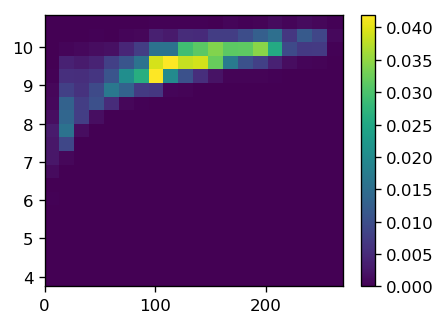

In [15]:
Nbins = 20
x_bins = np.linspace(dist.min(), dist.max(), Nbins+1)
y_bins = np.linspace(logMH.min(), logMH.max(), Nbins+1)


stat = binned_statistic_2d(dist, logMH, values=logMH, statistic='count', bins=[x_bins, y_bins])[0].T
stat = stat/np.sum(stat)
XX, YY = np.meshgrid(x_bins, y_bins)

plt.figure(dpi=120, figsize=(4,3))
plt.pcolor(XX, YY, stat)
plt.colorbar()
plt.show()

In [16]:
xcent = p.bin_centers(x_bins)
ycent = p.bin_centers(y_bins)

def stat_interp(dist, mass):
    xi = np.abs(xcent-dist).argmin()
    yi = np.abs(ycent-mass).argmin()
    return stat[yi, xi]



mindist = dist.min()
maxdist = dist.max()
minlogMH = logMH.min()
maxlogMH = logMH.max()
RAmin, RAmax = np.deg2rad(RA.min()), np.deg2rad(RA.max())
arcsinDECmin, arcsinDECmax = np.arcsin(np.deg2rad(DEC.min())), np.arcsin(np.deg2rad(DEC.max()))

def get_random():
    while True:
        rand_dist = np.random.uniform(mindist, maxdist)
        rand_mass = np.random.uniform(minlogMH, maxlogMH)
        rand_prob = np.random.uniform()
        keep_prob = stat_interp(rand_dist, rand_mass)
        if keep_prob > rand_prob:        
            rand_RA = np.rad2deg(np.random.uniform(RAmin, RAmax))
            rand_DEC = np.rad2deg(np.arcsin(np.random.uniform(arcsinDECmin, arcsinDECmax)))
            return rand_RA, rand_DEC, rand_dist, rand_mass

        
# Generate everything!
Ntest = 93399
randlogMH = np.zeros(Ntest)
randRA = np.zeros(Ntest)
randDEC = np.zeros(Ntest)
randdist = np.zeros(Ntest)

for i in range(Ntest):
    rand_RAi, rand_DECi, rand_disti, rand_massi = get_random()
    randlogMH[i] = rand_massi
    randdist[i] = rand_disti
    randRA[i] = rand_RAi
    randDEC[i] = rand_DECi
    
# Cluster the galaxies for jackknifing
N = randRA.size
Ncluster = 10000
IDS = np.random.choice(np.arange(N), Ncluster, False)
X = np.vstack([randRA[IDS], randDEC[IDS]]).T
km = kmeans_radec.kmeans_sample(X, p.ncent, maxiter=250, tol=1.0e-5, verbose=0)

X = np.vstack([randRA, randDEC]).T
randLabels = km.find_nearest(X)

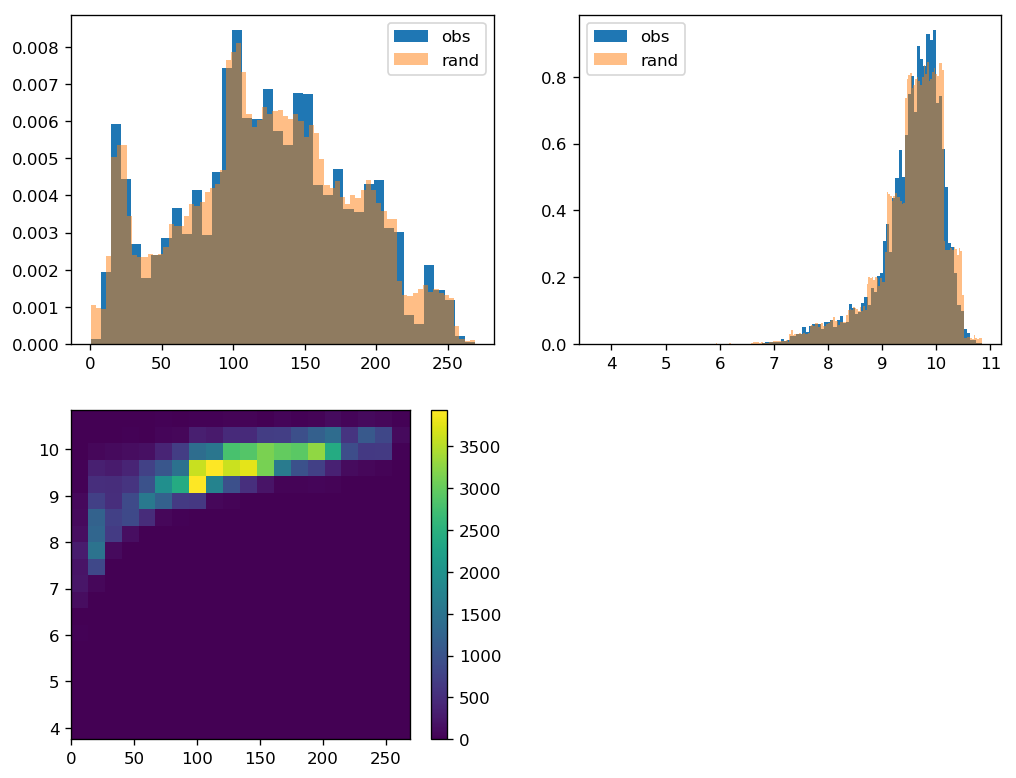

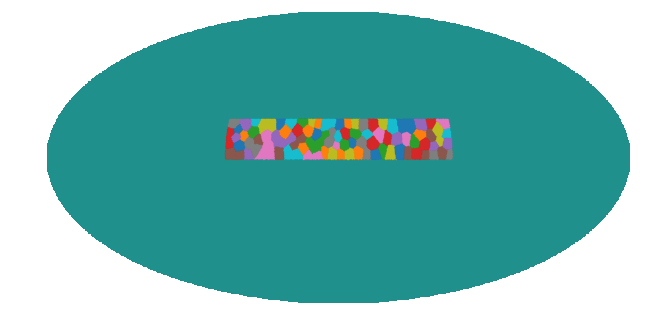

In [17]:
stat_rand = binned_statistic_2d(randdist, randlogMH, values=randlogMH, statistic='count',
                                bins=[x_bins, y_bins])[0].T

plt.figure(dpi=120, figsize=(10, 8))

plt.subplot(221)
plt.hist(dist, bins='auto', label='obs', density=1)
plt.hist(randdist, bins='auto', density=1, label='rand', alpha=0.5)
plt.legend()

plt.subplot(222)
plt.hist(logMH, bins='auto', label='obs', density=1)
plt.hist(randlogMH, bins='auto', density=1, label='rand', alpha=0.5)
plt.legend()

plt.subplot(223)
plt.pcolor(XX, YY, stat_rand)
plt.colorbar()

plt.show()


hp.mollview(np.zeros(12), rot=180, cbar=False, title='')
for label in np.unique(km.labels):
    IDS = np.where(randLabels == label)
    hp.projscatter(np.pi/2-np.deg2rad(randDEC[IDS]), np.deg2rad(randRA[IDS]), s=0.05)
plt.show()

We have 79077 galaxies in random.
We have 10422 galaxies in observation.


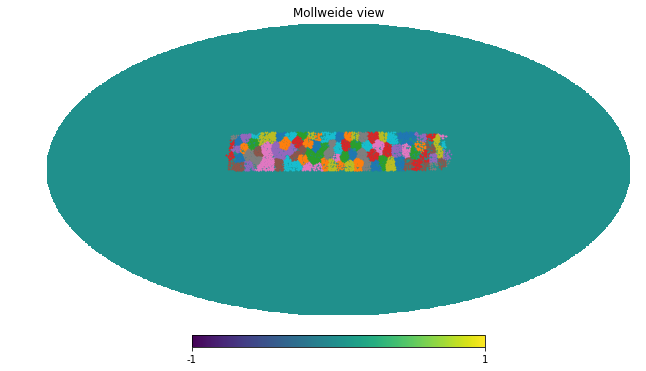

In [18]:
logMHlim = 9.0
perc = "HItestM2"

IDS = np.where(randlogMH > logMHlim)
N = randdist[IDS].size
print("We have {} galaxies in random.".format(N))

random_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'label', 'weights'),
                                'formats':('float64', 'float64', 'float64', 'int64', 'float64')})
random_catalog['ra'] = randRA[IDS]
random_catalog['dec'] = randDEC[IDS]
random_catalog['dist'] = randdist[IDS]
random_catalog['label'] = randLabels[IDS]
random_catalog['weights'] = get_weights(randdist[IDS])
# random_catalog['weights'] = np.ones_like(randRA[IDS])

np.save("../../Data/SMmatching/CFrandcatSM_{}_.npy".format(perc), random_catalog)

IDS = np.where(logMH>logMHlim)
N = dist[IDS].size
print("We have {} galaxies in observation.".format(N))

cut_catalog = np.zeros(N, dtype={'names':('ra', 'dec', 'dist', 'weights', 'label'),
                                'formats':('float64', 'float64', 'float64', 'float64', 'int64')})
cut_catalog['ra'] = RA[IDS]
cut_catalog['dec'] = DEC[IDS]
cut_catalog['dist'] = dist[IDS]
cut_catalog['label'] = km.find_nearest(X = np.vstack([RA[IDS], DEC[IDS]]).T)
cut_catalog['weights'] = get_weights(dist[IDS])
# cut_catalog['weights'] = np.ones_like(RAcut)

np.save("../../Data/SMmatching/CFcatSM_{}_.npy".format(perc), cut_catalog)

hp.mollview(np.zeros(12), rot=180)
for label in np.unique(km.labels):
    IDSlab = np.where(label==cut_catalog['label'])
    hp.projscatter(np.pi/2-np.deg2rad(DEC[IDS])[IDSlab], np.deg2rad(RA[IDS])[IDSlab], s=0.5)

In [ ]:
!ls ../../Data/SMmatching/